# ДЗ 3.3: Использование модели включающей в себя Conv3D.


## Импортируем необходимые пакеты, подключаем диск. Считываем файл с разметкой.

In [2]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm


In [ ]:
from torchvision.io import read_video
from torch.utils.data import Dataset, DataLoader
import av
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import torch.nn.functional as F

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/videos/data.csv")
df = df.drop(columns=['Unnamed: 0'])
df.head()

## Посмотрим на баланс классов в выборке.

<Axes: xlabel='label', ylabel='Count'>

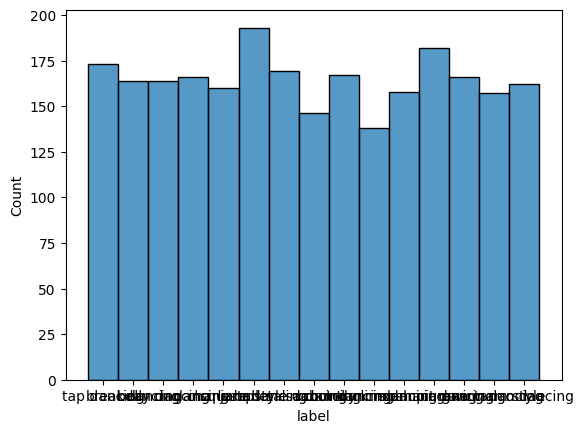

In [ ]:
sns.histplot(df['label'], )

In [ ]:
unique_values = np.unique(df['label'])
mapping = {unique_values[i]: i for i in range(len(unique_values))}
df['label'] = df['label'].apply(lambda x: mapping[x])

## Класс MyDataset

`MyDataset` - это пользовательский класс для обработки видеоданных, наследующий от класса `Dataset`. Этот класс подготавливает данные для использования в машинном обучении, особенно для задач видеоанализа.

### Конструктор `__init__`

- `data`: Данные, которые нужно обработать. Ожидается, что это будет DataFrame, содержащий информацию о видеофайлах.
- `self.df`: DataFrame, который сохраняется в экземпляр класса для последующей обработки.

### Метод `__len__`

Возвращает количество записей в DataFrame, что соответствует количеству обрабатываемых видеофайлов.

### Метод `__getitem__`

Получает видео по индексу `idx`:

- `row`: Строка DataFrame, соответствующая данному индексу, содержит метки и названия файлов видео.
- `label`: Метка класса для видео.
- `path`: Путь к файлу видео.
- `video`: Загруженное видео с использованием функции `read_video`.

Видео далее обрабатывается для создания единообразного формата входных данных:

1. **Регулировка размера кадров видео**: Если длина видео превышает заданный порог, оно усекается или ресемплируется для сокращения количества кадров до значений 100, 200, 400, 600, 800 или 1000, в зависимости от исходной длины.
2. **Дополнение видео**: Если длина видео меньше 100 кадров, оставшиеся кадры заполняются нулями.
3. **Трансформация кадров**: Переформатирование каждого кадра к размеру 128x128, нормализация значений пикселей с использованием заданных средних значений и стандартных отклонений.

### Возвращаемые значения

- `video_normalized`: Тензор, содержащий обработанное видео, готовый для использования в модели машинного обучения.
- `label`: Тензор, содержащий метку класса видео, преобразованную в тип `long`.

Этот класс предназначен для удобной загрузки и предобработки видеоданных для задач компьютерного зрения, особенно для обучения моделей глубокого обучения.


In [ ]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.df = data

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        label = row['label']
        path = '/content/drive/MyDrive/' + row['name_video']
        video, _, _ = read_video(path, pts_unit="sec")
        if len(video) >= 100:
            if len(video) > 1000:
                video = video[:1000:10]
            elif 800 < len(video) <= 1000:
                video = video[:800:8]
            elif 600 < len(video) <= 800:
                video = video[:600:6]
            elif 400 < len(video) <= 600:
                video = video[:400:4]
            elif 200 < len(video) <= 400:
                video = video[:200:2]
            else:
                video = video[:100]
        else:
            f = []
            for i in range(100):
                if i < video.shape[0]:
                    f.append(video[i])
                else:
                    f.append(torch.zeros_like(video[0]))
            video = torch.cat(f, dim=0).reshape((100, video.shape[1], video.shape[2], video.shape[3]))
        video = video.numpy()
        video = torch.tensor(video)
        resize_transform = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize((128, 128)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])])
        video_resized = torch.stack([resize_transform(frame.permute(2, 0, 1)).permute(1, 2, 0) for frame in video])
        video_normalized = video_resized.permute(3, 0, 1, 2)
        label = torch.tensor(label).long()
        return video_normalized, label

### Описание класса Block_3D

`Block_3D` — это модуль нейронной сети, предназначенный для использования в архитектурах, работающих с трёхмерными данными, например, в видеоанализе. Этот класс наследуется от `nn.Module` и реализует типичный блок с пропускными соединениями (residual connections).

#### Конструктор

- `in_features`: Количество входных каналов.
- `middle_features`: Количество каналов после первого свёрточного слоя.
- `out_features`: Количество выходных каналов.
- Внутри конструктора создаётся последовательность операций (`nn.Sequential`), включая свёртки (`nn.Conv3d`), пакетную нормализацию (`nn.BatchNorm3d`) и функцию активации ReLU. Также определено отдельное "downsampling" преобразование для обеспечения совместимости размерностей входных и выходных данных при сложении.

#### Метод `forward`

- `x`: Входной тензор.
- Процесс обработки включает пропускание данных через основную последовательность слоёв, добавление результата к преобразованному входу (residual connection) и применение функции активации ReLU для получения итогового выхода.

Этот блок обычно используется в глубоких нейронных сетях для улучшения обучения и уменьшения проблемы исчезающего градиента за счёт добавления прямого пути передачи сигнала.


In [ ]:
class Block_3D(nn.Module):
    def __init__(self, in_features, middle_features, out_features):
        super(Block_3D, self).__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_features, middle_features, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), bias=False),
            nn.BatchNorm3d(middle_features),
            nn.ReLU(inplace=True),
            nn.Conv3d(middle_features, out_features, kernel_size=(1, 3, 3), padding=(0, 1, 1), bias=False),
            nn.BatchNorm3d(out_features),
        )
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
            nn.Conv3d(in_features, out_features, kernel_size=(1, 1, 1), stride=(1, 2, 2), bias=False),
            nn.BatchNorm3d(out_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

    def forward(self, x):
        out = self.net(x)
        residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
model = nn.Sequential(
    #nn.Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 3, 3), bias=False),
    #nn.BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    #nn.ReLU(inplace=True),
    #Block_Big(64, 64, 64),
    #Block_Big(64, 64, 64),
    Block_3D(3, 32, 64),
    Block_3D(64, 128, 128),
    #Block_Small(128, 128, 128),
    Block_3D(128, 256, 256),
    #Block_Small(256, 256, 256),
    Block_3D(256, 128, 128),
    #Block_Small(512, 512, 512),
    nn.AdaptiveAvgPool3d((1, 1, 1)),
    nn.Flatten(),
    nn.Linear(in_features=128, out_features=15)
)

### Тут проверим какого размера у нас получилась модель.

```
# Выбран кодовый формат
```



In [ ]:
sum(p.numel() for p in model.parameters())

1646831

## Загружаем датасеты, инициализируем потимизатор для лупа обучения.

In [ ]:
df_now = df.sample(20)
train, test = train_test_split(df, test_size=0.2, stratify=df['label'])

In [ ]:
train_dataset = MyDataset(train.reset_index())
test_dataset = MyDataset(test.reset_index())

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
cel = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0025)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,11,14], gamma=0.1)

## Тренировочный цикл модели

Этот блок кода описывает процесс тренировки и валидации модели машинного обучения за фиксированное количество эпох.

#### Параметры цикла

- `for epoch in range(16)`: Итерации тренировки проходят через 16 эпох.

#### Основные шаги в каждой эпохе

1. **Инициализация переменных**:
   - `mean_train_loss` и `mean_test_loss` для средней потери на тренировочных и тестовых данных.
   - `right_pred_train` и `right_pred_test` для подсчета правильных предсказаний.
   - `len_train` и `len_test` для подсчета общего количества образцов в тренировочном и тестовом наборах.

2. **Тренировка**:
   - `model.train()` переключает модель в режим тренировки.
   - Итерации по тренировочным данным с помощью `tqdm` для визуализации прогресса.
   - Для каждого батча данные и метки переносятся на устройство обработки, выполняются предсказания модели, вычисляется и обратно распространяется ошибка, обновляются веса.

3. **Валидация**:
   - `model.eval()` переключает модель в режим оценки.
   - Аналогично тренировке, итерации по тестовым данным для оценки производительности модели без обратного распространения ошибки.

4. **Логирование результатов**:
   - Расчет и вывод средних потерь и точности для тренировочных и тестовых данных.
   - Отображение текущего значения скорости обучения.

5. **Сохранение модели**:
   - Модель сохраняется каждые 5 эпох для возможности восстановления или дальнейшего анализа.

#### Дополнительные замечания

- Использование `detach().cpu()` предотвращает утечку памяти и переносит данные с устройства обработки для дальнейшего использования в CPU.
- `F.softmax` используется для вычисления вероятностей классов перед определением предсказанного класса.
- Планировщик (`scheduler.step()`) обновляет скорость обучения в зависимости от политики планирования.

In [ ]:
for epoch in range(16):
    print(f"_______epoch{epoch}_____")
    model.train()
    mean_train_loss = 0
    mean_test_loss = 0
    right_pred_test = 0
    right_pred_train = 0
    len_train = 0
    len_test = 0
    train_tqdm = tqdm(train_dataloader)

    for X, y in (train_tqdm):
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        res = model(X)
        loss = cel(res, y)
        train_tqdm.update()
        loss.backward()
        optimizer.step()
        loss = loss.detach().cpu()
        res = res.detach().cpu()
        y = y.detach().cpu()
        mean_train_loss += loss * len(y)
        len_train += len(y)
        train_tqdm.set_description_str(f"loss: {loss}")
        preds = torch.max(F.softmax(res, dim=1), dim=1)
        right_pred_train += len(preds[1][preds[1] == y])

    model.eval()
    test_tqdm = tqdm(test_dataloader)
    with torch.no_grad():
        for X, y in (test_tqdm):
            X = X.to(device)
            y = y.to(device)
            res = model(X)
            loss = cel(res, y)
            loss = loss.detach().cpu()
            res = res.detach().cpu()
            y = y.detach().cpu()
            mean_test_loss += loss * len(y)
            len_test += len(y)
            test_tqdm.set_description(f"loss: {loss}")
            preds = torch.max(F.softmax(res, dim=1), dim=1)
            right_pred_test += len(preds[1][preds[1] == y])

    mean_train_loss = mean_train_loss / len_train
    mean_test_loss = mean_test_loss / len_test
    acc_test = right_pred_test / len_test
    acc_train = right_pred_train / len_train
    print(f"train_loss: {mean_train_loss:.3f}| test_loss: {mean_test_loss:.3f}")
    print(f"accuracy train: {acc_train:.3f} | accuracy test: {acc_test:.3f}")
    print(f"lr {optimizer.param_groups[0]['lr']} in epoch {epoch}")
    scheduler.step()
    if epoch % 5 == 0:
      torch.save(model.state_dict(), "/content/drive/MyDrive/" + str(epoch) + "CV__shared.pt")

_______epoch0_____


loss: 2.7657570838928223: 100%|██████████| 62/62 [13:37<00:00, 13.18s/it]


train_loss: 2.721| test_loss: 2.771
accuracy train: 0.101 | accuracy test: 0.118
lr 0.0025 in epoch 0
_______epoch1_____


loss: 2.463223934173584: 100%|██████████| 62/62 [06:40<00:00,  6.46s/it]


train_loss: 2.661| test_loss: 2.674
accuracy train: 0.109 | accuracy test: 0.136
lr 0.0025 in epoch 1
_______epoch2_____


loss: 2.868283748626709: 100%|██████████| 62/62 [06:39<00:00,  6.45s/it]


train_loss: 2.644| test_loss: 2.646
accuracy train: 0.115 | accuracy test: 0.134
lr 0.0025 in epoch 2
_______epoch3_____


loss: 2.390275716781616: 100%|██████████| 62/62 [06:35<00:00,  6.38s/it]


train_loss: 2.629| test_loss: 2.609
accuracy train: 0.132 | accuracy test: 0.156
lr 0.0025 in epoch 3
_______epoch4_____


loss: 2.5931549072265625: 100%|██████████| 62/62 [06:38<00:00,  6.43s/it]


train_loss: 2.606| test_loss: 2.651
accuracy train: 0.137 | accuracy test: 0.122
lr 0.0025 in epoch 4
_______epoch5_____


loss: 2.8402929306030273: 100%|██████████| 62/62 [06:33<00:00,  6.34s/it]


train_loss: 2.595| test_loss: 2.630
accuracy train: 0.147 | accuracy test: 0.144
lr 0.0025 in epoch 5
_______epoch6_____


loss: 2.7080631256103516: 100%|██████████| 62/62 [06:37<00:00,  6.42s/it]


train_loss: 2.544| test_loss: 2.563
accuracy train: 0.169 | accuracy test: 0.164
lr 0.00025 in epoch 6
_______epoch7_____


loss: 2.670466899871826: 100%|██████████| 62/62 [06:45<00:00,  6.54s/it]


train_loss: 2.516| test_loss: 2.543
accuracy train: 0.194 | accuracy test: 0.170
lr 0.00025 in epoch 7
_______epoch8_____


loss: 2.8294968605041504: 100%|██████████| 62/62 [06:37<00:00,  6.41s/it]


train_loss: 2.511| test_loss: 2.531
accuracy train: 0.184 | accuracy test: 0.176
lr 0.00025 in epoch 8
_______epoch9_____


loss: 2.7818074226379395: 100%|██████████| 62/62 [06:30<00:00,  6.29s/it]


train_loss: 2.492| test_loss: 2.540
accuracy train: 0.186 | accuracy test: 0.170
lr 0.00025 in epoch 9
_______epoch10_____


loss: 2.7299513816833496: 100%|██████████| 62/62 [06:35<00:00,  6.37s/it]


train_loss: 2.477| test_loss: 2.536
accuracy train: 0.185 | accuracy test: 0.189
lr 0.00025 in epoch 10
_______epoch11_____


loss: 2.753934144973755: 100%|██████████| 62/62 [06:36<00:00,  6.39s/it]


train_loss: 2.449| test_loss: 2.520
accuracy train: 0.203 | accuracy test: 0.183
lr 2.5e-05 in epoch 11
_______epoch12_____


loss: 2.2300572395324707:   4%|▎         | 9/247 [00:42<17:22,  4.38s/it]



```
__epoch12
loss: 2.4920406341552734: 100%|██████████| 247/247 [29:53<00:00, 7.26s/it]
loss: 2.506084442138672: 100%|██████████| 62/62 [06:22<00:00, 6.17s/it]
train_loss: 2.431| test_loss: 2.510
accuracy train: 0.215 | accuracy test: 0.195
lr 2.5e-05 in epoch 12
__epoch13
loss: 2.455209255218506: 100%|██████████| 247/247 [30:15<00:00, 7.35s/it]
loss: 2.478292465209961: 100%|██████████| 62/62 [06:35<00:00, 6.38s/it]
train_loss: 2.422| test_loss: 2.487
accuracy train: 0.224 | accuracy test: 0.201
lr 2.5e-05 in epoch 13
__epoch14
loss: 2.407191276550293: 100%|██████████| 247/247 [29:58<00:00, 7.28s/it]
loss: 2.4228720664978027: 100%|██████████| 62/62 [06:25<00:00, 6.21s/it]
train_loss: 2.401| test_loss: 2.458
accuracy train: 0.235 | accuracy test: 0.212
lr 2.5e-05 in epoch 14
__epoch15
loss: 2.3776354789733887: 100%|██████████| 247/247 [29:54<00:00, 7.27s/it]
loss: 2.397711276123047: 100%|██████████| 62/62 [06:28<00:00, 6.26s/it]
train_loss: 2.387| test_loss: 2.441
accuracy train: 0.243 | accuracy test: 0.225
lr 2.5e-05 in epoch 15
__epoch16
loss: 2.351329803466797: 100%|██████████| 247/247 [29:49<00:00, 7.25s/it]
loss: 2.3729090690612793: 100%|██████████| 62/62 [06:23<00:00, 6.19s/it]
train_loss: 2.376| test_loss: 2.423
accuracy train: 0.251 | accuracy test: 0.232
lr 2.5e-05 in epoch 16
__epoch17
loss: 2.3249197006225586: 100%|██████████| 247/247 [30:01<00:00, 7.29s/it]
loss: 2.3480935096740723: 100%|██████████| 62/62 [06:31<00:00, 6.32s/it]
train_loss: 2.365| test_loss: 2.409
accuracy train: 0.258 | accuracy test: 0.239
lr 2.5e-05 in epoch 17
__epoch18
loss: 2.2980833053588867: 100%|██████████| 247/247 [29:57<00:00, 7.28s/it]
loss: 2.323225975036621: 100%|██████████| 62/62 [06:27<00:00, 6.25s/it]
train_loss: 2.354| test_loss: 2.395
accuracy train: 0.267 | accuracy test: 0.245
lr 2.5e-05 in epoch 18
```





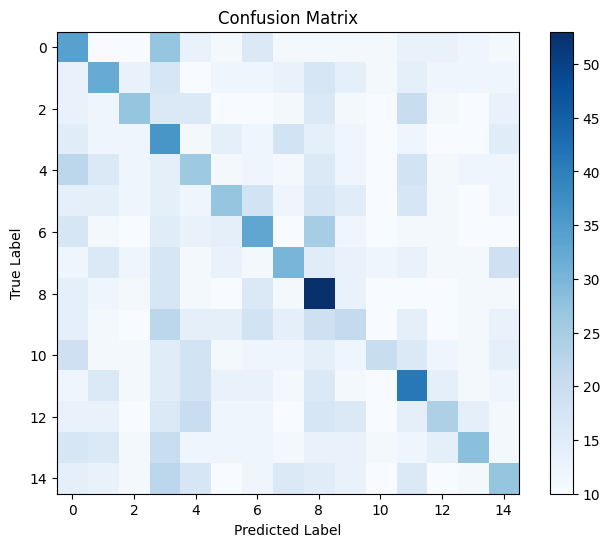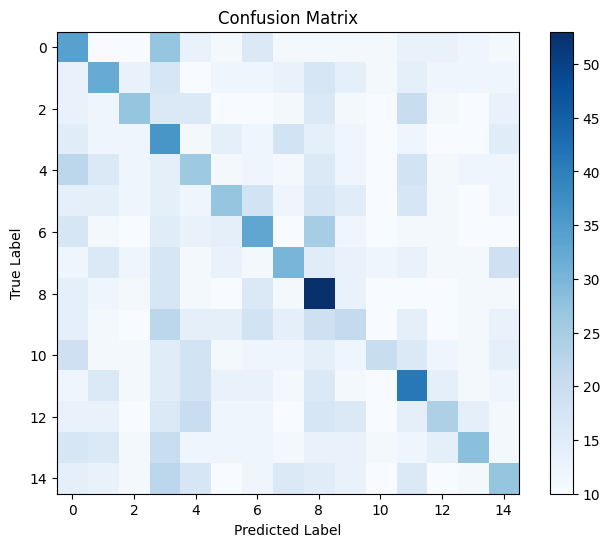